# Dependencies

In [20]:
# Main
import pandas as pd
import numpy as np
import requests

# Dash
import dash
from dash import html
from dash import dcc
from jupyter_dash import JupyterDash
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Resources

In [21]:
# Color Themes
colors = {
    'background': '#3a3f44',
    'text': '#aaa',
    'Scatter': ['#BB3E3E','#BB5C3E','#B47E3C','#98A437','#609D34','#3CB4AA','#4062BF','#4040BF','#7740BF','#9940BF','#BF4099','#D788CA','#DEB19C','#DFD19F','#BEE9E5','#50241B','#0F260D','#0B040A'],
    'Bar': ['rgb(255, 0, 98)', 'rgb(167, 0, 255)', 'rgb(0, 77, 255)']
}

# Data

In [22]:
# API Pull Census.gov
censusUrl = 'https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP&for=county:009,063,067,069,071,089,101,117,121,135,167,185,199,209,303,317&in=state:13'
censusRes = requests.get(censusUrl).json()
censusDf = pd.DataFrame(censusRes[1:], columns = censusRes[0])
censusDf = censusDf.astype({'POP':'float'})[['NAME', 'POP']]
censusDf = censusDf.replace(', Georgia','', regex = True)
censusDf = censusDf.rename(columns = {'NAME': 'County_Name', 'POP': 'Population'})
censusDf['Population'] = censusDf['Population'].astype('float').astype('int')
censusDf

,County_Name,Population
0,Washington County,20374
1,Gwinnett County,936250
2,Johnson County,9643
3,Wilkes County,9777
4,Clayton County,292256
5,Fulton County,1063937
6,Montgomery County,9172
7,Baldwin County,44890
8,Echols County,4006
9,DeKalb County,759297


In [23]:
# GA County Stores
countyPath = '../ellisResources/GA_Counties_Stores.csv'
countyDf = pd.read_csv(countyPath).sort_values(by = 'County_Name', ascending = True).replace(',','', regex = True).drop(columns = ['Latitude', 'Longitude'])
countyDf['Per_Capita_Income'] = countyDf['Per_Capita_Income'].astype('float').astype('int')
countyDf

,County_Name,Per_Capita_Income,Percent_FRL,Total_Grocery_Stores,Total_Dollar_Stores,Total_Fast_Food_Places
5,Baldwin County,36399,92.88,4,14,25
2,Clayton County,32702,92.55,9,25,25
13,Cobb County,63214,39.14,15,25,25
4,Coffee County,35507,87.34,2,15,24
6,Colquitt County,37418,86.21,3,11,19
12,DeKalb County,56428,68.56,17,25,25
1,Echols County,31945,91.26,0,0,0
14,Forsyth County,67859,13.68,10,15,25
15,Fulton County,95683,42.17,20,25,25
11,Gwinnett County,46886,50.30,18,25,25


In [24]:
# Merge DF
countyDf = countyDf.merge(censusDf, how = 'left', on = 'County_Name').sort_values(by = 'Population', ascending = True)
countyDf

,County_Name,Per_Capita_Income,Percent_FRL,Total_Grocery_Stores,Total_Dollar_Stores,Total_Fast_Food_Places,Population
6,Echols County,31945,91.26,0,0,0,4006
13,Montgomery County,34061,94.83,0,2,2,9172
10,Johnson County,27965,94.38,1,2,1,9643
15,Wilkes County,42093,94.17,1,5,4,9777
14,Washington County,39151,85.62,1,5,8,20374
12,Meriwether County,39121,88.02,1,3,0,21167
3,Coffee County,35507,87.34,2,15,24,43273
0,Baldwin County,36399,92.88,4,14,25,44890
4,Colquitt County,37418,86.21,3,11,19,45600
11,Lowndes County,41117,43.76,7,22,25,117406


# Dash

In [28]:
# County Population & Per Capita Income
def PopAndIncome():
    fig = make_subplots(rows = 1,
                        cols = 2,
                        specs = [[{}, {}]],
                        shared_xaxes = True,
                        shared_yaxes = False,
                        vertical_spacing = 0.001)
    fig.append_trace(go.Bar(x = countyDf['Population'].array,
                            y = countyDf['County_Name'].array,
                            marker = dict(color = colors['Scatter']),
                            name = 'Population',
                            orientation = 'h',
                           ), 1, 1)
    fig.append_trace(go.Scatter(x = countyDf['Per_Capita_Income'].array,
                                y = countyDf['County_Name'],
                                mode = 'lines+markers',
                                line_color = 'green',
                                name = 'Per Capita Income'
                               ), 1, 2)
    fig.update_layout(title = 'County Population & Per Capita Income',
                      yaxis = dict(showgrid = False,
                                   showline = False,
                                   showticklabels = True,
                                   linecolor = 'rgba(102, 102, 102, 0.8)',
                                   linewidth = 2,
                                   domain = [0, 0.85]),
                      yaxis2 = dict(showgrid = False,
                                    showline = True,
                                    showticklabels = False,
                                    linecolor = 'rgba(102, 102, 102, 0.8)',
                                    linewidth = 2,
                                    domain = [0, 0.85]),
                      xaxis = dict(zeroline = False,
                                   showline = False,
                                   showticklabels = True,
                                   showgrid = True,
                                   domain = [0, 0.42]),
                      xaxis2 = dict(zeroline = False,
                                    showline = False,
                                    showticklabels = True,
                                    showgrid = True,
                                    domain = [0.47, 1],
                                    side = 'top',
                                    dtick = 10000),
                      showlegend = False,
                      margin = dict(l = 100,
                                    r = 20,
                                    t = 70,
                                    b = 70))
    
    annotations = []
    for row in countyDf.values:
        annotations.append(dict(xref = 'x2',
                                yref = 'y2',
                                y = row[0],
                                x = row[1] - 15000,
                                text = '$' + '{:,}'.format(row[1]) + 'K',
                                font = dict(family = 'Arial',
                                            size = 12),
                                showarrow = False))
    fig.update_layout(annotations = annotations)
    return fig
    
# Store Count by County
def StoreCount():
    fig = px.bar(countyDf,
                x = 'County_Name',
                y = ['Total_Grocery_Stores', 'Total_Dollar_Stores', 'Total_Fast_Food_Places'],
                text_auto = True,
                color_discrete_sequence = colors['Bar'])
    fig.update_layout(title = 'Store Count by County',
                      xaxis_title = 'County',
                      yaxis_title = 'Store Counts',
                      xaxis = { 'categoryorder': 'total descending' })
    return fig

# % FRL vs Per Capita Income
def FRLvIncome():
    fig = px.scatter(countyDf.sort_values(by = 'Percent_FRL', ascending = True),
                     x = 'Per_Capita_Income',
                     y = 'Percent_FRL',
                     color = 'County_Name',
                     color_discrete_sequence = colors['Scatter'])
    fig.update_layout(title = '% FRL vs Per Capita Income',
                      xaxis_title = 'Per Capita Income',
                      yaxis_title = '% FRL')
    fig.update_traces(mode='markers',
                      marker_line_width = 2,
                      marker_size = 15)
    return fig

# % FRL vs Grocery Stores
def FRLvGrocery():
    fig = px.scatter(countyDf.sort_values(by = 'Percent_FRL', ascending = True),
                     x = 'Total_Grocery_Stores',
                     y = 'Percent_FRL',
                     color = 'County_Name',
                     color_discrete_sequence = colors['Scatter'])
    fig.update_layout(title = '% FRL vs Total_Grocery_Stores',
                      xaxis_title = 'Total_Grocery_Stores',
                      yaxis_title = '% FRL')
    fig.update_traces(mode='markers',
                      marker_line_width = 2,
                      marker_size = 15)
    return fig

# NARRATIVE ANALYSIS:

## Chart #1
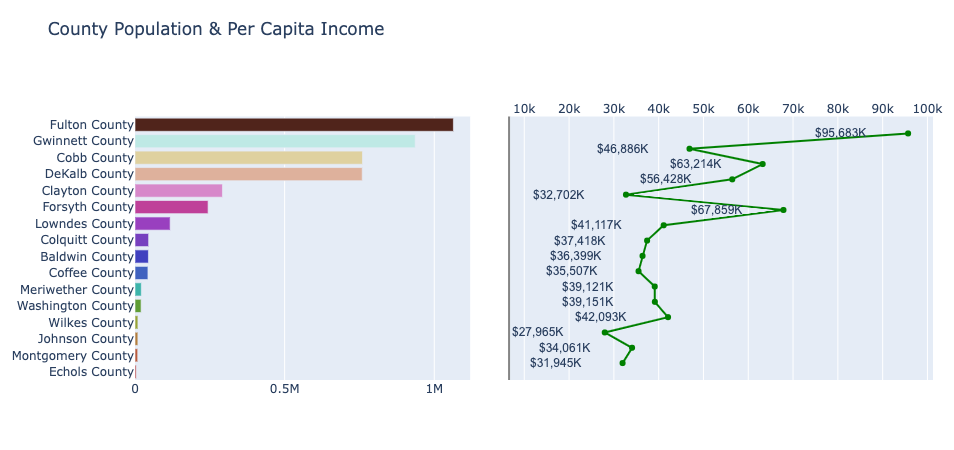
These 2 graphs show the correlation between County Population and Per Capita Income.  Counties with a high population tend to have a higher Per Capita Income than those with a lower population.

## Chart #2
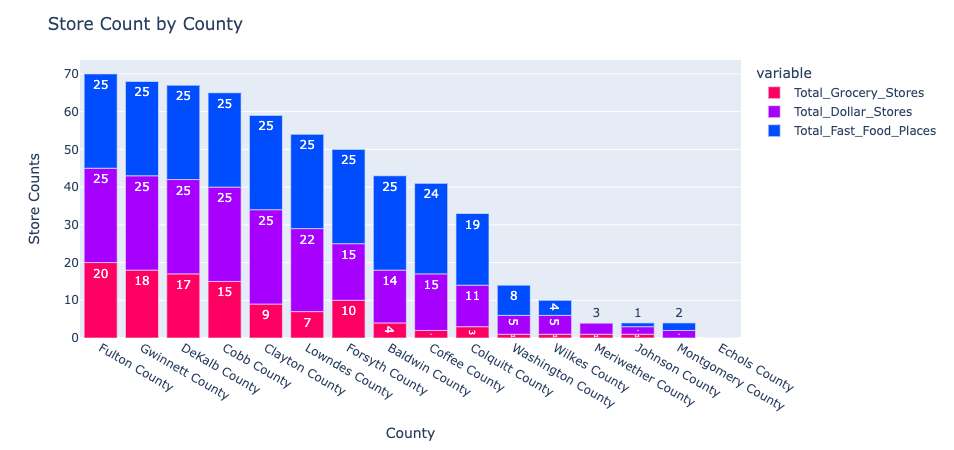
The graph shows that there is a moderate pattern of equal distribution of Fast Food, Dollar and Grocery Stores. There are many confounding variables that may influence this behavior pattern, but one variable may be due to the population of each county. A higher population may lead to more stores than a lower population.

## Chart #3
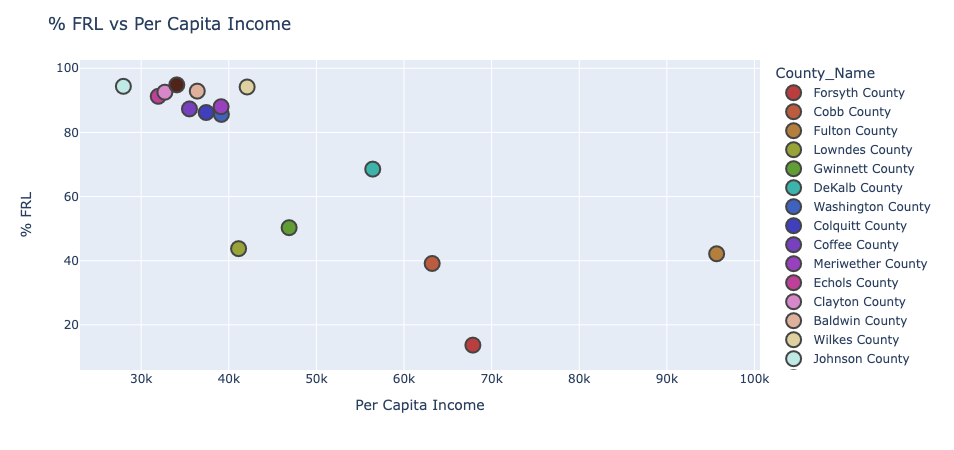
The graph shows that there is a weak negative correlation between a county's % FRL and it's Per Capita Income. There is a cluster of counties located where the % FRL is high and the Per Capita Income level is low. The high % FRL may be due to the low Per Capita Income level of that county. As the Per Capita Income level of a county increases, the % FRL decreases. The low % FRL may be due to the high Per Capita Income level of that county.

## Chart #4
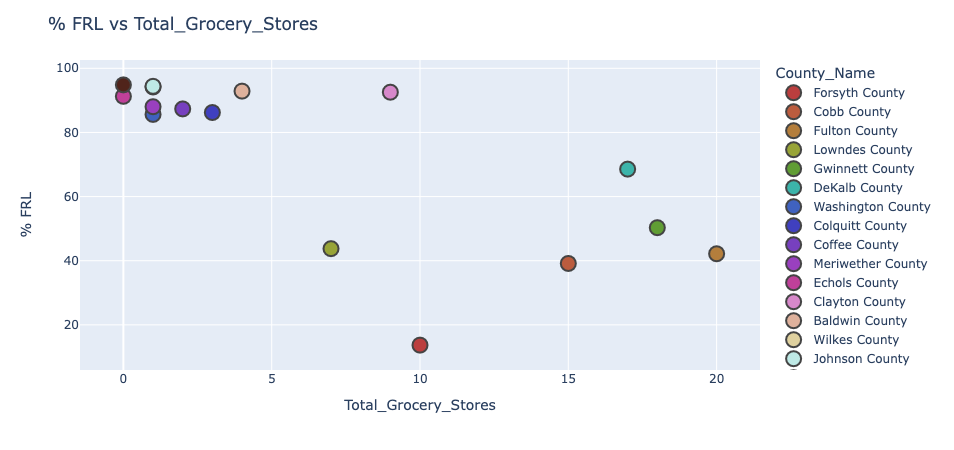
Like Chart #3, this graph shows a weak negative correlation between a county's % FRL and it's Total Grocery Stores. There is a cluster of counties located where the % FRL is high and the Grocery Store count is low. The high % FRL may be due to the low Per Capita Income level of that county. As the Grocery Stores count of a county increases, the % FRL tend to decrease. 

In [29]:
# Initialize
app = JupyterDash(__name__)

# App Layout
app.layout = html.Div([
    dcc.Graph(figure = PopAndIncome()),
    html.P('''
    These 2 graphs show the correlation between County Population and Per Capita Income.
    Counties with a high population tend to have a higher Per Capita Income than those with a lower population.
    '''),
    
    dcc.Graph(figure = StoreCount()),
    html.P('''
    The graph shows that there is a moderate pattern of equal distribution of Fast Food, Dollar, and Grocery Stores.
    There are many confounding variables that may influence this behavior pattern, but one variable may be due to
    the population of each county. A higher population may lead to more stores than a lower population.
    '''),
    
    dcc.Graph(figure = FRLvIncome()),
    html.P('''
    The graph shows that there is a weak negative correlation between a county\'s % FRL and it's Per Capita Income.
    There is a cluster of counties located where the % FRL is high and the Per Capita Income level is low.
    The high % FRL may be due to the low Per Capita Income level of that county.
    As the Per Capita Income level of a county increases, the % FRL decreases.
    The low % FRL may be due to the high Per Capita Income level of that county.
    '''),
    
    dcc.Graph(figure = FRLvGrocery()),
    html.P('''
    Like Chart #3, this graph shows a weak negative correlation between a county's % FRL and it's Total Grocery Stores.
    There is a cluster of counties located where the % FRL is high and the Grocery Store count is low. 
    The high % FRL may be due to the low Per Capita Income level of that county. 
    As the Grocery Stores count of a county increases, the % FRL tend to decrease. 
    '''),
    
])

# Run App
app.run_server(mode = 'inline')